2025-03-17 13:52:38.849 | INFO | chain_utils:load_hotkey_keypair:54 - Loaded keypair from /Users/matiasmartinez/.bittensor/wallets/sn165-miner/hotkeys/miner1
2025-03-17 13:52:38.849 | INFO | interface:_get_chain_endpoint:21 - Using the chain network: test and therefore chain address: wss://test.finney.opentensor.ai:443/
2025-03-17 13:52:42.389 | INFO | interface:get_substrate:36 - Connected to wss://test.finney.opentensor.ai:443/
2025-03-17 13:52:42.390 | INFO | metagraph:load_nodes:86 - Loading nodes from nodes.json
2025-03-17 13:52:42.390 | INFO | metagraph:sync_nodes:64 - Syncing nodes...
2025-03-17 13:52:42.390 | INFO | interface:_get_chain_endpoint:14 - Using chain address: wss://test.finney.opentensor.ai:443/
2025-03-17 13:52:48.252 | INFO | interface:get_substrate:36 - Connected to wss://test.finney.opentensor.ai:443/
2025-03-17 13:52:48.627 | INFO | metagraph:sync_nodes:67 - ******************** NODES: [Node(hotkey='5FKshidf4CaKUA3hsrKfWcNKUAt6JDbwyANgnXD6rmxJPWGx', coldkey='5C

TypeError: 'module' object is not callable

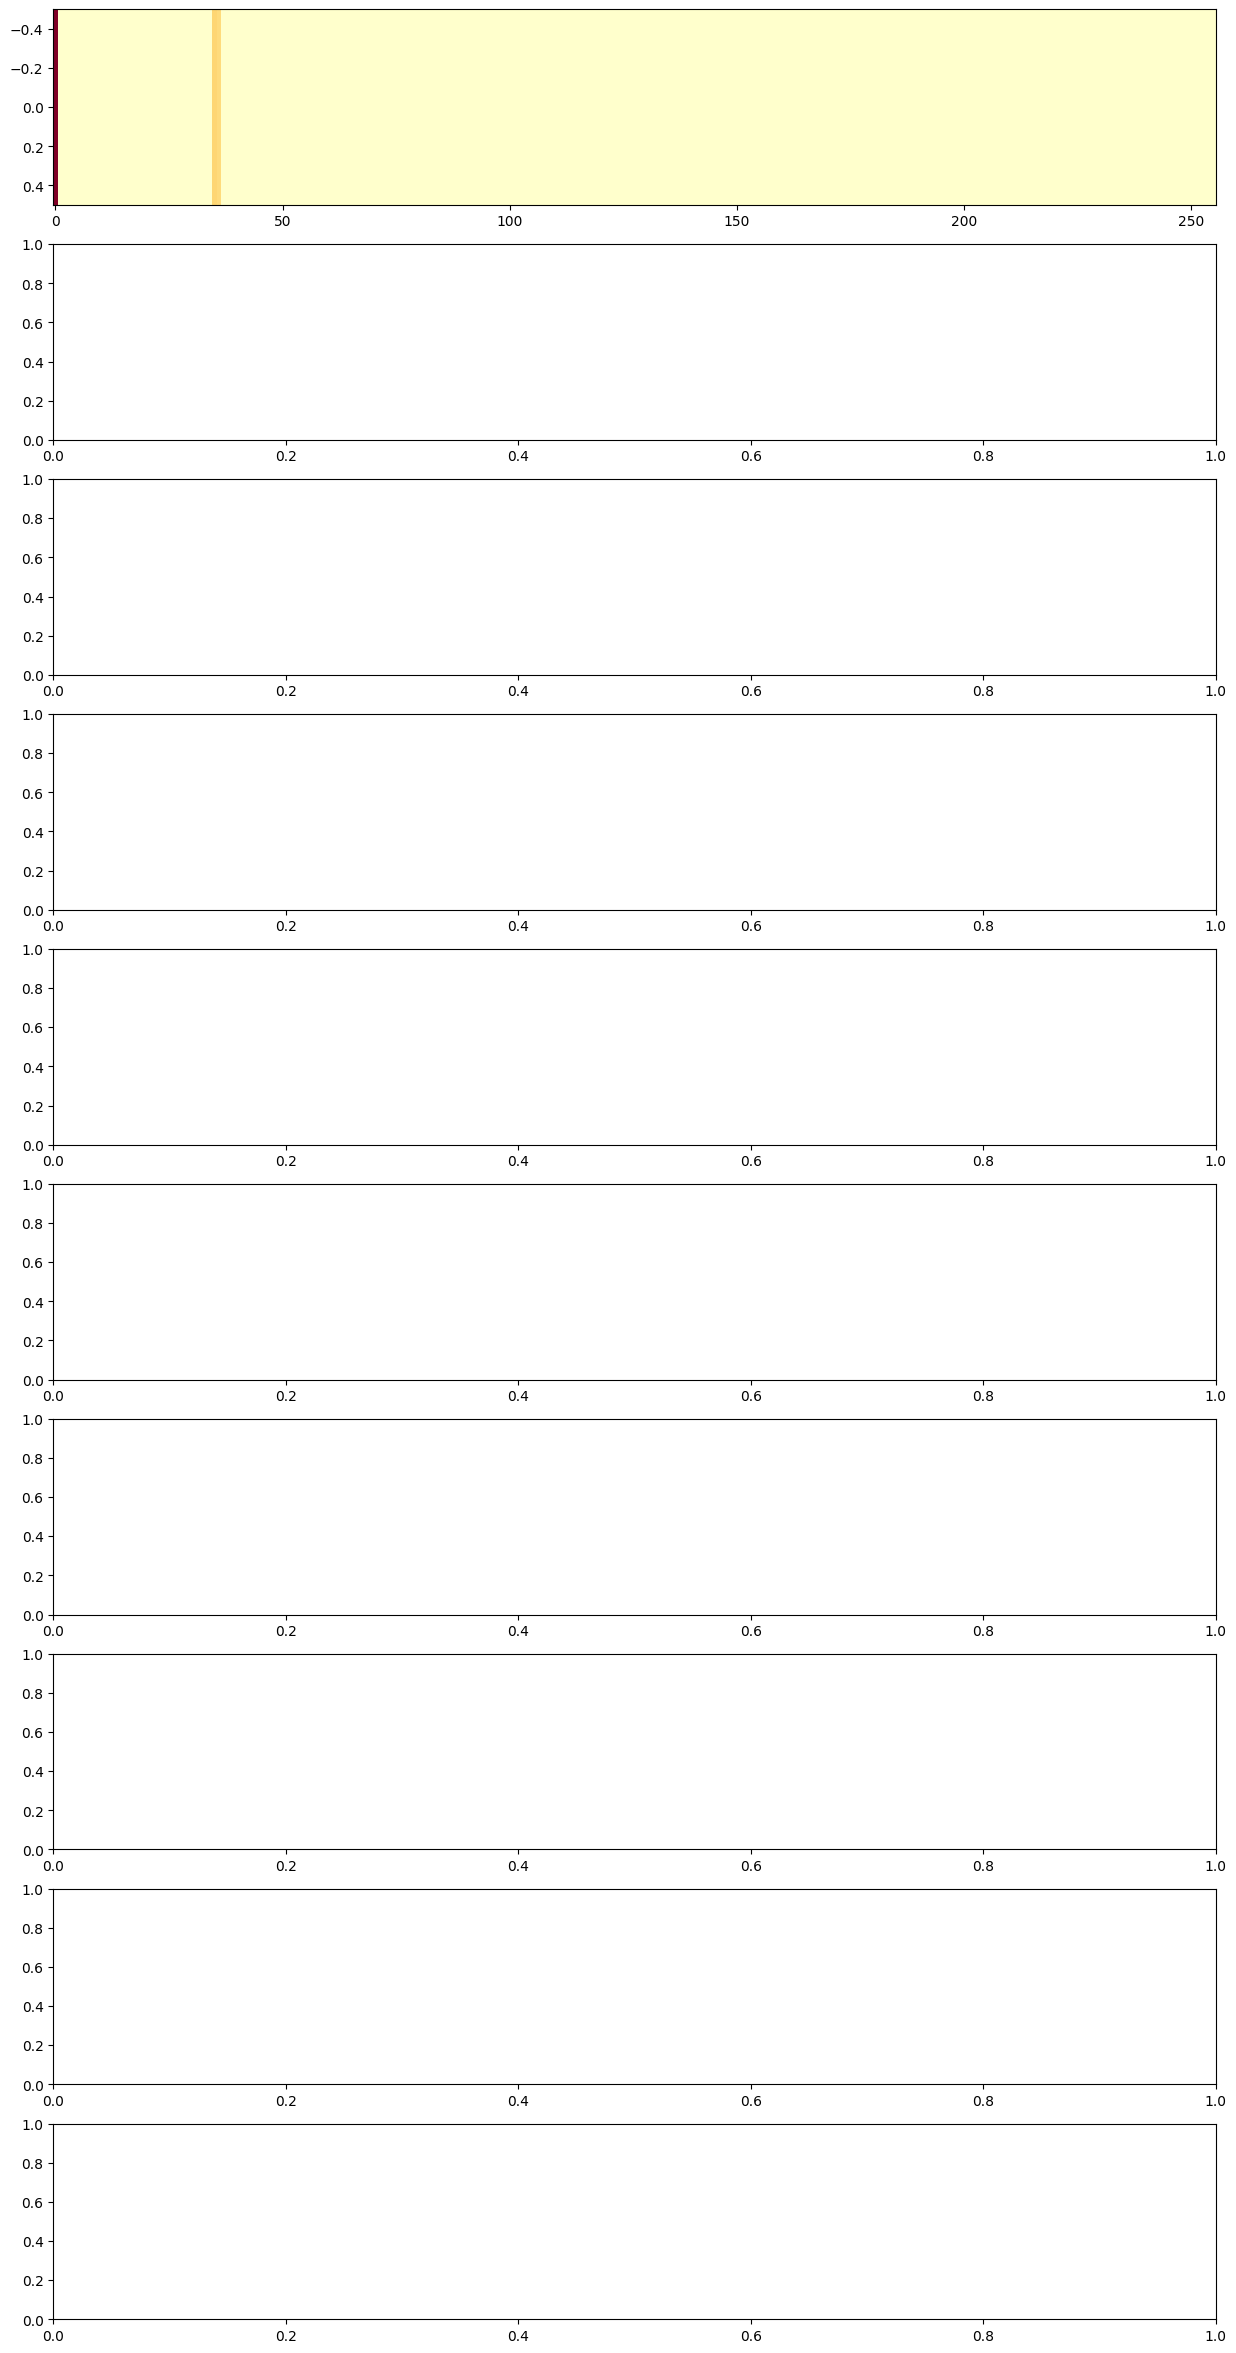

In [27]:
import sys
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import humanize
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

from neurons.miner import AgentMiner
from miner.utils import get_validators_permits, get_validators_weight, get_last_updated

# Initialize miner to access chain data
miner = AgentMiner()

# Get data
vpermits = get_validators_permits(miner)
last_updated = get_last_updated(miner)

# Convert permits to boolean array
permits_bool = [bool(p) for p in vpermits]

# Get weights data and last updated info for validators with permits
weights_data = []
last_updated_with_permits = []
validator_ids = []
for uid, has_permit in enumerate(permits_bool):
    if has_permit:
        weights = get_validators_weight(miner, uid)
        weights_data.append(weights)
        last_updated_with_permits.append(last_updated[uid])
        validator_ids.append(uid)

# Create a figure with stacked horizontal heatmaps for each validator with non-zero weights
# Filter out weights_data items that sum to 0
weights_data = [weights for weights in weights_data if sum(weights) > 0]
# Also filter corresponding validator_ids
validator_ids = [
    vid for vid, weights in zip(validator_ids, weights_data) if sum(weights) > 0
]


n_nodes = len(last_updated)
if n_nodes > 0:

    weights_list = []
    for uid, updated in enumerate(last_updated):
        weights = get_validators_weight(miner, uid)
        weights_list.append(weights)

    # Count number of validators with non-zero total weights
    non_zero_weights = sum(1 for weights in weights_list if sum(weights) > 0)
    print(f"\nNumber of validators with non-zero total weights: {non_zero_weights}")

    # Create figure - one row per validator
    fig, axes = plt.subplots(non_zero_weights, 1, figsize=(15, 3 * non_zero_weights))

    # Convert single axis to array if only one validator
    if n_nodes == 1:
        axes = np.array([axes])

    # Filter weights_list to only include non-zero weights while preserving indices
    non_zero_indices = []
    filtered_weights_list = []
    for idx, weights in enumerate(weights_list):
        if sum(weights) > 0:
            filtered_weights_list.append(weights)
            non_zero_indices.append(idx)

    weights_list = filtered_weights_list
    # Plot horizontal heatmap for each validator's weights
    for idx, (weights, vid) in enumerate(zip(filtered_weights_list, non_zero_indices)):

        # Reshape weights into row vector for horizontal heatmap
        weights_array = np.array(weights).reshape(1, -1)

        # Create horizontal heatmap
        im = axes[idx].imshow(weights_array, aspect="auto", cmap="YlOrRd")
        delta = timedelta(minutes=last_updated[vid]*12/60)
        axes[idx].set_title(
            f"Weights Set by Validator {vid} (Last updated {last_updated[vid]} blocks / {humanize.naturaldelta(delta)} ago)"
        )
        axes[idx].set_yticks([])  # Remove y-axis ticks since we only have one row

        # Add x-axis labels for UIDs
        axes[idx].set_xticks(range(len(weights)))
        axes[idx].set_xticklabels([f"{i}" for i in range(len(weights))], rotation=45)

        # Add colorbar
        plt.colorbar(
            im, ax=axes[idx], orientation="horizontal", label="Weight", pad=0.35
        )

    plt.suptitle("Validator Weights Distribution", y=1.02)
    plt.tight_layout()
    plt.show()


# Calculate total unique weights received by each UID
total_uids = len(last_updated)  # Total number of UIDs in the network
unique_weights_received = np.zeros(total_uids)

# For each validator's weights
for weights in weights_data:
    # For each possible UID in the network
    for uid in range(total_uids):
        # If this validator gave a non-zero weight to this UID
        if weights[uid] != 0:
            unique_weights_received[uid] += 1

# Print results for each UID
for uid in range(total_uids):
    print(f"UID {uid}: got {int(unique_weights_received[uid])} unique weights")

# Create heatmap of non-zero weights received
plt.figure(figsize=(10, 6))
unique_weights_array = unique_weights_received.reshape(-1, 1)
im = plt.imshow(unique_weights_array, aspect="auto", cmap="YlOrRd")
plt.title("Number of Non-Zero Weights Received")
plt.xlabel("Count")
plt.ylabel("Validator UID")
plt.yticks(range(total_uids), [f"UID {i}" for i in range(total_uids)])
plt.colorbar(im, label="Number of Non-Zero Weights")
plt.tight_layout()
plt.show()

if weights_data:
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot last updated heatmap
    last_updated_array = np.array(last_updated_with_permits).reshape(-1, 1)
    im1 = ax1.imshow(last_updated_array, aspect="auto", cmap="YlOrRd")
    ax1.set_title("Blocks Since Last Update")
    ax1.set_xlabel("Last Updated")
    ax1.set_ylabel("Validator UID")
    ax1.set_yticks(range(len(validator_ids)))
    ax1.set_yticklabels([f"V{vid}" for vid in validator_ids])
    plt.colorbar(im1, ax=ax1, label="Blocks")

    # Plot weights heatmap
    im2 = ax2.imshow(weights_data, aspect="auto", cmap="viridis")
    ax2.set_title("Validator Weights")
    ax2.set_xlabel("Node ID")
    ax2.set_ylabel("Validator UID")
    ax2.set_yticks(range(len(validator_ids)))
    ax2.set_yticklabels([f"V{vid}" for vid in validator_ids])
    plt.colorbar(im2, ax=ax2, label="Weight Value")

    plt.tight_layout()
    plt.show()